In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_plt
import yfinance as yf

In [2]:
#loading closing prices for Apple and Microsoft from the past 2 years into a dataframe
tickers = ["AAPL", "MSFT"]
price_data = pd.DataFrame()
for ticker in tickers:
    price_data[ticker] = yf.download(ticker, period = "2y")["Close"]

num_of_assets = len(tickers)
num_of_days = len(price_data)

print(price_data.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                  AAPL        MSFT
Date                              
2022-06-27  141.660004  264.890015
2022-06-28  137.440002  256.480011
2022-06-29  139.229996  260.260010
2022-06-30  136.720001  256.829987
2022-07-01  138.929993  259.579987


In [3]:
#separating data into data for use and data for backtesting
use_data = price_data.iloc[:int(num_of_days*0.5)]
test_data = price_data.iloc[int(num_of_days*0.5):]

In [4]:
#calculating risk-free return
one_year_bond = 0.05
inflation = 0.02
risk_free_return = one_year_bond - inflation

#calculating log returns
log_returns = np.log(1+use_data.pct_change())

#function that inputs weights and outputs annual return, standard deviation, sharpe ratio 
def get_metrics(weights):
    weights = np.array(weights)
    annual_returns = np.sum(252*log_returns.mean()*weights)
    standard_dev = np.sqrt(np.dot(weights.T, np.dot(252*log_returns.cov(), weights)))
    sharpe_ratio = (annual_returns-risk_free_return)/standard_dev
    return np.array([annual_returns, standard_dev, sharpe_ratio])

#function to check sum of weights equals 1
def check_weights(weights):
    return np.sum(weights)-1

In [5]:
#functions to be minimized
def get_neg_annual_returns(weights):
    return -1*get_metrics(weights)[0]
def get_standard_dev(weights):
    return get_metrics(weights)[1]
def get_neg_sharpe_ratio(weights):
    return -1*get_metrics(weights)[2]

#initial weights, bounds, and constraints
initial = num_of_assets*[1/num_of_assets]
bounds = tuple((0, 1) for ticker in tickers)
constraints = ({"type": "eq", "fun": check_weights})

#minimizing the functions
maximize_annual_returns = sci_plt.minimize(get_neg_annual_returns, initial, bounds = bounds, constraints = constraints)
minimize_standard_dev = sci_plt.minimize(get_standard_dev, initial, bounds = bounds, constraints = constraints)
maximize_sharpe_ratio = sci_plt.minimize(get_neg_sharpe_ratio, initial, bounds = bounds, constraints = constraints)

In [6]:
#getting the annual return, standard deviation, sharpe ratios

#maximized annual return
annual_returns_1 = get_metrics(maximize_annual_returns.x)[0]
standard_dev_1 = get_metrics(maximize_annual_returns.x)[1]
sharpe_ratio_1 = get_metrics(maximize_annual_returns.x)[2]

#minimized standard deviation
annual_returns_2 = get_metrics(minimize_standard_dev.x)[0]
standard_dev_2 = get_metrics(minimize_standard_dev.x)[1]
sharpe_ratio_2 = get_metrics(minimize_standard_dev.x)[2]

#maximized sharpe ratio
annual_returns_3 = get_metrics(maximize_sharpe_ratio.x)[0]
standard_dev_3 = get_metrics(maximize_sharpe_ratio.x)[1]
sharpe_ratio_3 = get_metrics(maximize_sharpe_ratio.x)[2]

Maximizing annual returns 

Annual returns: 0.279
Standard Deviation: 0.297
Sharpe Ratio: 0.839


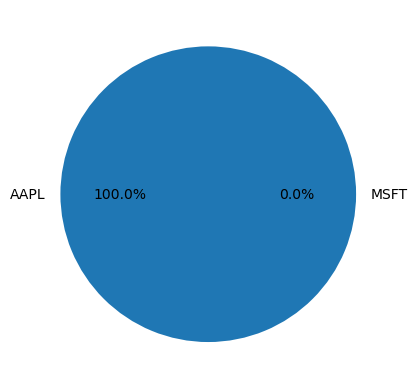

Minimizing standard deviation 

Annual returns: 0.265
Standard Deviation: 0.286
Sharpe Ratio: 0.821


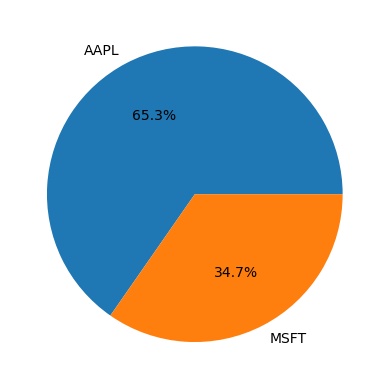

Maximizing sharpe ratio 

Annual returns: 0.276
Standard Deviation: 0.293
Sharpe Ratio: 0.841


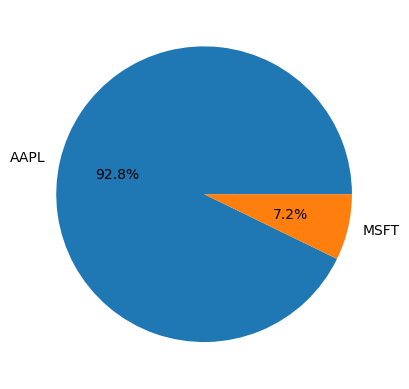

In [7]:
#displaying results

#maximized annual return
print("Maximizing annual returns \n")
print("Annual returns:", round(annual_returns_1, 3))
print("Standard Deviation:", round(standard_dev_1, 3))
print("Sharpe Ratio:", round(sharpe_ratio_1, 3))

#pie chart of weights
plt.pie(maximize_annual_returns.x, labels = tickers, autopct = "%1.1f%%")
plt.show()

#minimized standard deviation
print("Minimizing standard deviation \n")
print("Annual returns:", round(annual_returns_2, 3))
print("Standard Deviation:", round(standard_dev_2, 3))
print("Sharpe Ratio:", round(sharpe_ratio_2, 3))

#pie chart of weights
plt.pie(minimize_standard_dev.x, labels = tickers, autopct = "%1.1f%%")
plt.show()

#maximized sharpe ratio
print("Maximizing sharpe ratio \n")
print("Annual returns:", round(annual_returns_3, 3))
print("Standard Deviation:", round(standard_dev_3, 3))
print("Sharpe Ratio:", round(sharpe_ratio_3, 3))

#pie chart of weights
plt.pie(maximize_sharpe_ratio.x, labels = tickers, autopct = "%1.1f%%")
plt.show()

Text(0.29296914106811434, 0.27629094516854436, 'Maximum sharpe ratio')

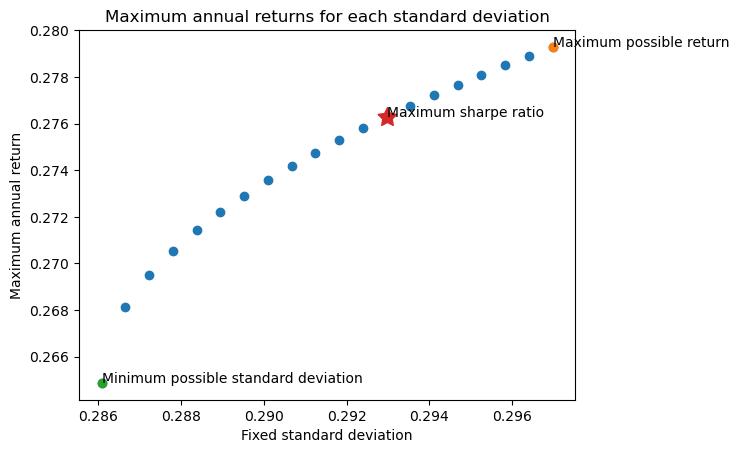

In [8]:
#finding the maximum annual return for a fixed standard deviation

#array of standard deviations
fixed_sd = np.linspace(standard_dev_2, standard_dev_1, 20)

#maximizing annual returns for each fixed standard deviation
annual_returns_4 = []
standard_dev_4 = []
sharpe_ratio_4 = []
for sd in fixed_sd:
    def check_standard_dev(weights):
        return sd-get_metrics(weights)[1]
    standard_dev_constraints = ({"type": "ineq", "fun": check_standard_dev})
    fixed_maximize_annual_returns = sci_plt.minimize(get_neg_annual_returns, initial, bounds = bounds, constraints = [constraints, standard_dev_constraints])

    #arrays of corresponding annual returns, standard deviations, sharpe ratios
    annual_returns_4.append(get_metrics(fixed_maximize_annual_returns.x)[0])
    standard_dev_4.append(get_metrics(fixed_maximize_annual_returns.x)[1])
    sharpe_ratio_4.append(get_metrics(fixed_maximize_annual_returns.x)[2])

#scatter plot 
plt.xlabel("Fixed standard deviation")
plt.ylabel("Maximum annual return")
plt.title("Maximum annual returns for each standard deviation")
plt.scatter(standard_dev_4, annual_returns_4)

#maximum annual return
plt.scatter(standard_dev_1, annual_returns_1)

#minimum standard deviation
plt.scatter(standard_dev_2, annual_returns_2)

#maximum sharpe ratio
plt.scatter(standard_dev_3, annual_returns_3, marker = (5, 1, 0), s = 200)

#annotations
plt.annotate("Maximum possible return", (standard_dev_1, annual_returns_1))
plt.annotate("Minimum possible standard deviation", (standard_dev_2, annual_returns_2))
plt.annotate("Maximum sharpe ratio", (standard_dev_3, annual_returns_3))

Text(0.27629094516854436, 0.29296914106811434, 'Maximum sharpe ratio')

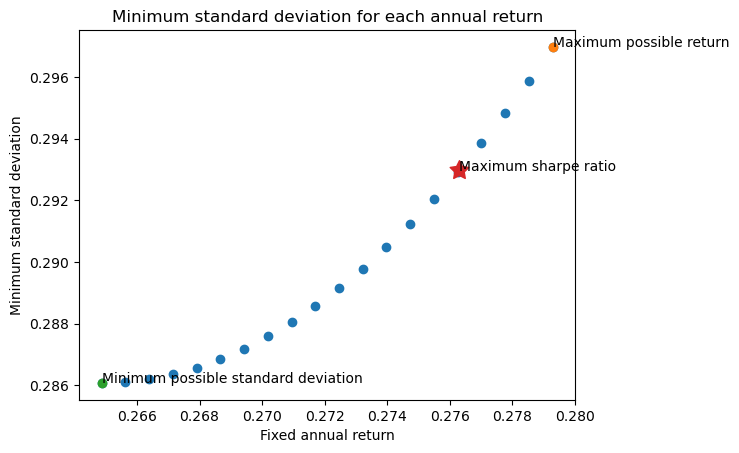

In [9]:
#finding the maximum annual return for a fixed standard deviation

#array of standard deviations
fixed_ar = np.linspace(annual_returns_1, annual_returns_2, 20)

#maximizing annual returns for each fixed standard deviation
annual_returns_5 = []
standard_dev_5 = []
sharpe_ratio_5 = []
for ar in fixed_ar:
    def check_annual_returns(weights):
        return get_metrics(weights)[0]-ar
    annual_returns_constraints = ({"type": "ineq", "fun": check_annual_returns})
    fixed_minimize_sd = sci_plt.minimize(get_standard_dev, initial, bounds = bounds, constraints = [constraints, annual_returns_constraints])
    
    #arrays of corresponding annual returns, standard deviations, sharpe ratios
    annual_returns_5.append(get_metrics(fixed_minimize_sd.x)[0])
    standard_dev_5.append(get_metrics(fixed_minimize_sd.x)[1])
    sharpe_ratio_5.append(get_metrics(fixed_minimize_sd.x)[2])

#scatter plot 
plt.xlabel("Fixed annual return")
plt.ylabel("Minimum standard deviation")
plt.title("Minimum standard deviation for each annual return")
plt.scatter(annual_returns_5, standard_dev_5)

#maximum annual return
plt.scatter(annual_returns_1, standard_dev_1)

#minimum standard deviation
plt.scatter(annual_returns_2, standard_dev_2)

#maximum sharpe ratio
plt.scatter(annual_returns_3, standard_dev_3, marker = (5, 1, 0), s = 200)

#annotations
plt.annotate("Maximum possible return", (annual_returns_1, standard_dev_1))
plt.annotate("Minimum possible standard deviation", (annual_returns_2, standard_dev_2))
plt.annotate("Maximum sharpe ratio", (annual_returns_3, standard_dev_3))

In [10]:
#backtesting weights for maximum annual returns

log_returns = np.log(1+test_data.pct_change())
weights = maximize_annual_returns.x

annual_returns = np.sum(252*log_returns.mean()*weights)
standard_dev = np.sqrt(np.dot(weights.T, np.dot(252*log_returns.cov(), weights)))
sharpe_ratio = (annual_returns-risk_free_return)/standard_dev

print("Maximizing annual returns \n")
print("Annual returns:", round(annual_returns, 3))
print("Standard Deviation:", round(standard_dev, 3))
print("Sharpe Ratio:", round(sharpe_ratio, 3))

Maximizing annual returns 

Annual returns: 0.117
Standard Deviation: 0.218
Sharpe Ratio: 0.4


In [11]:
#backtesting weights for minimum standard deviation

weights = minimize_standard_dev.x

annual_returns = np.sum(252*log_returns.mean()*weights)
standard_dev = np.sqrt(np.dot(weights.T, np.dot(252*log_returns.cov(), weights)))
sharpe_ratio = (annual_returns-risk_free_return)/standard_dev

print("Minimizing standard deviation \n")
print("Annual returns:", round(annual_returns, 3))
print("Standard Deviation:", round(standard_dev, 3))
print("Sharpe Ratio:", round(sharpe_ratio, 3))

Minimizing standard deviation 

Annual returns: 0.185
Standard Deviation: 0.184
Sharpe Ratio: 0.841


In [12]:
#backtesting weights for maximum sharpe ratio

weights = maximize_sharpe_ratio.x

annual_returns = np.sum(252*log_returns.mean()*weights)
standard_dev = np.sqrt(np.dot(weights.T, np.dot(252*log_returns.cov(), weights)))
sharpe_ratio = (annual_returns-risk_free_return)/standard_dev

print("Maximizing sharpe ratio \n")
print("Annual returns:", round(annual_returns, 3))
print("Standard Deviation:", round(standard_dev, 3))
print("Sharpe Ratio:", round(sharpe_ratio, 3))

Maximizing sharpe ratio 

Annual returns: 0.131
Standard Deviation: 0.209
Sharpe Ratio: 0.485
